In [1]:
import numpy as np
import random
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from ensemble.distributions import distribution_dict
from ensemble.model import EnsembleFitter, EnsembleDistribution

# data = pd.read_csv("microdata_2024_05_03.csv", encoding="latin-1")
# data["year_id"] = np.around(np.mean(data["year_start"] / data["year_end"]), decimals=1)
# data = data[["nid", "location_id", "year_id", "sex", "age", "age_start3", "fpg_mmol"]]
data = pd.read_parquet("data/microdata_2024_05_03.parquet")
tmap = pd.read_csv("data/NAME_task_map.csv")
# print(tmap.columns)
# print(tmap[["location_id", "year_id", "sex_id", "age_cat"]].shape)
# temp = pd.read_csv("data/NAME_stgpr_result.csv")
# print(temp.columns)
# print(temp[["location_id", "year_id", "sex_id", "age_group_years_start"]].head())
# print(temp["age_group_alternative_name"].unique())

# print(temp[["location_id", "year_id", "sex_id", "age_group_years_start"]].drop_duplicates().shape)

# var = pd.read_csv("data/NAME_custom_sd_result.csv")
# print(var.columns)

0.12499999999999997 0.12499999999999997
(0.5, 0.19999999999999998)


ValueError: This distribution is only supposrted on [0, 1]

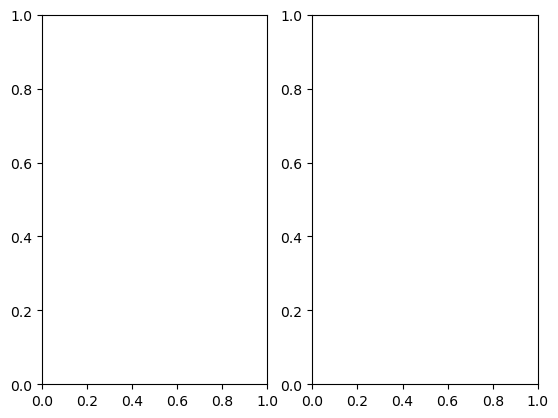

In [ ]:
# fig, ax = plt.subplots(1, 2)
# support = np.linspace(0, 1, 100)
# temp_beta = distribution_dict["Beta"](0.5, 0.2)
# sup = np.linspace(3, 5, 100)
# temp_mscabeta = distribution_dict["Beta"](4, 0.4, 3, 5)
# # print(temp_beta._scipy_dist)
# temp_pdf = temp_beta.pdf(support)
# ax[0].plot(support, temp_pdf)
# temp_msca_pdf = temp_mscabeta.pdf(sup)
# ax[1].plot(sup, temp_msca_pdf)

# Fitting individual distributions

hi! 1.8051140871074909 0.47424544588544415
0.375 0.125
0.328125 0.546875


/Users/maxbi/opt/anaconda3/envs/ensemble/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:2509: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


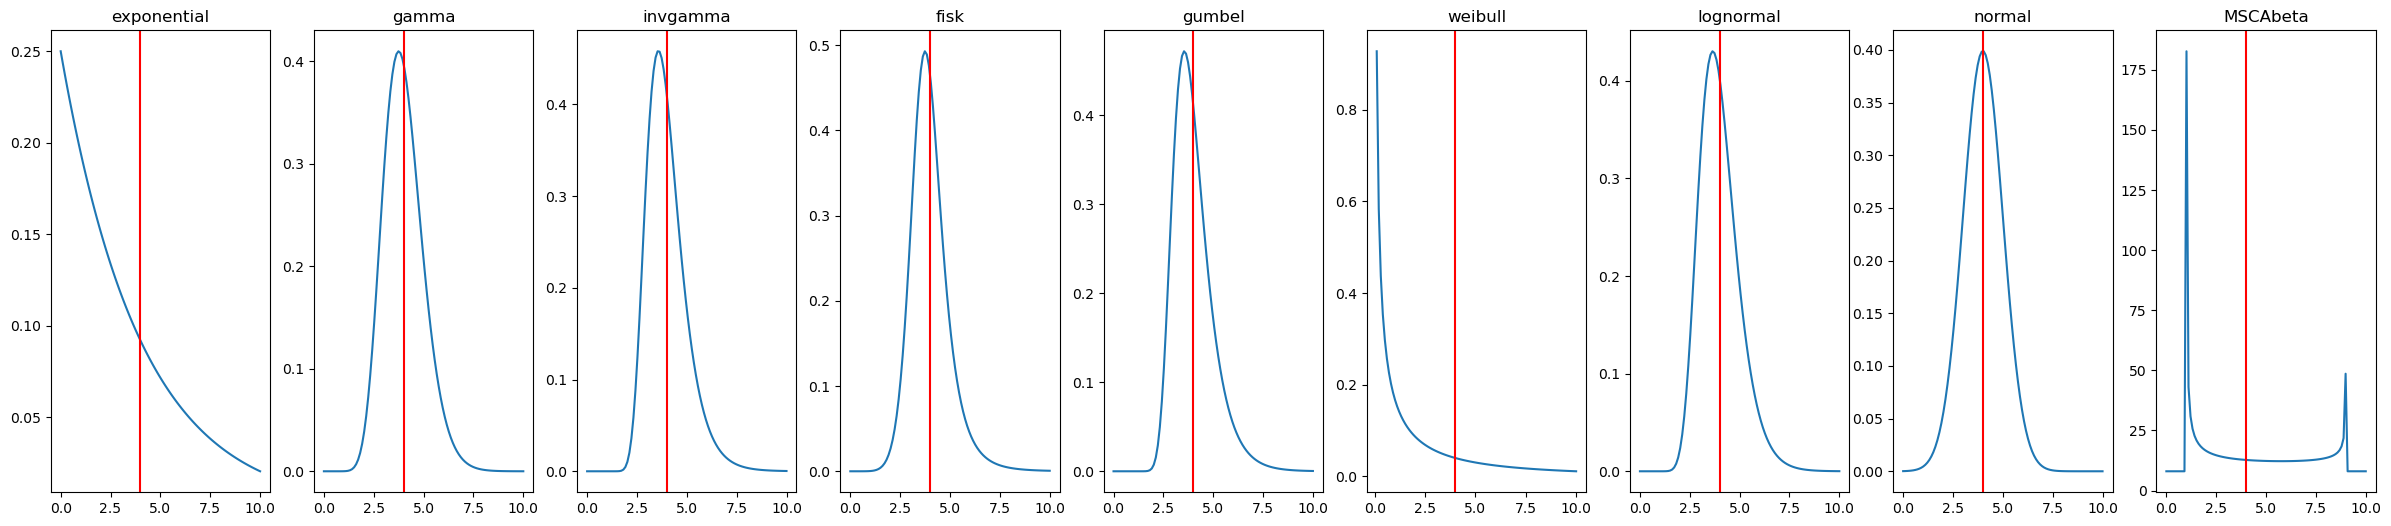

In [ ]:
MEAN = 4
VARIANCE = 1
fitted_distributions = {}
counter = 0
fig, ax = plt.subplots(1, len(distribution_dict) - 1, figsize=(30, 6))
for distribution in distribution_dict:
  # match distribution:
  #   case "beta":
  #     pass
  #   case _:
  #     fitted_distributions
  #     case "MSCAbeta":
  if distribution != "beta":
    if distribution == "MSCAbeta":
      fitted_distributions[distribution] = distribution_dict[distribution](MEAN, VARIANCE, 1, 9)
    else:
      fitted_distributions[distribution] = distribution_dict[distribution](MEAN, VARIANCE)
    support = np.linspace(0, 10, 100)
    pdf = fitted_distributions[distribution].pdf(support)
    ax[counter].plot(support, pdf)
    ax[counter].axvline(MEAN, color="red")
    ax[counter].title.set_text(distribution)
    counter += 1


# Fitting ensemble distributions

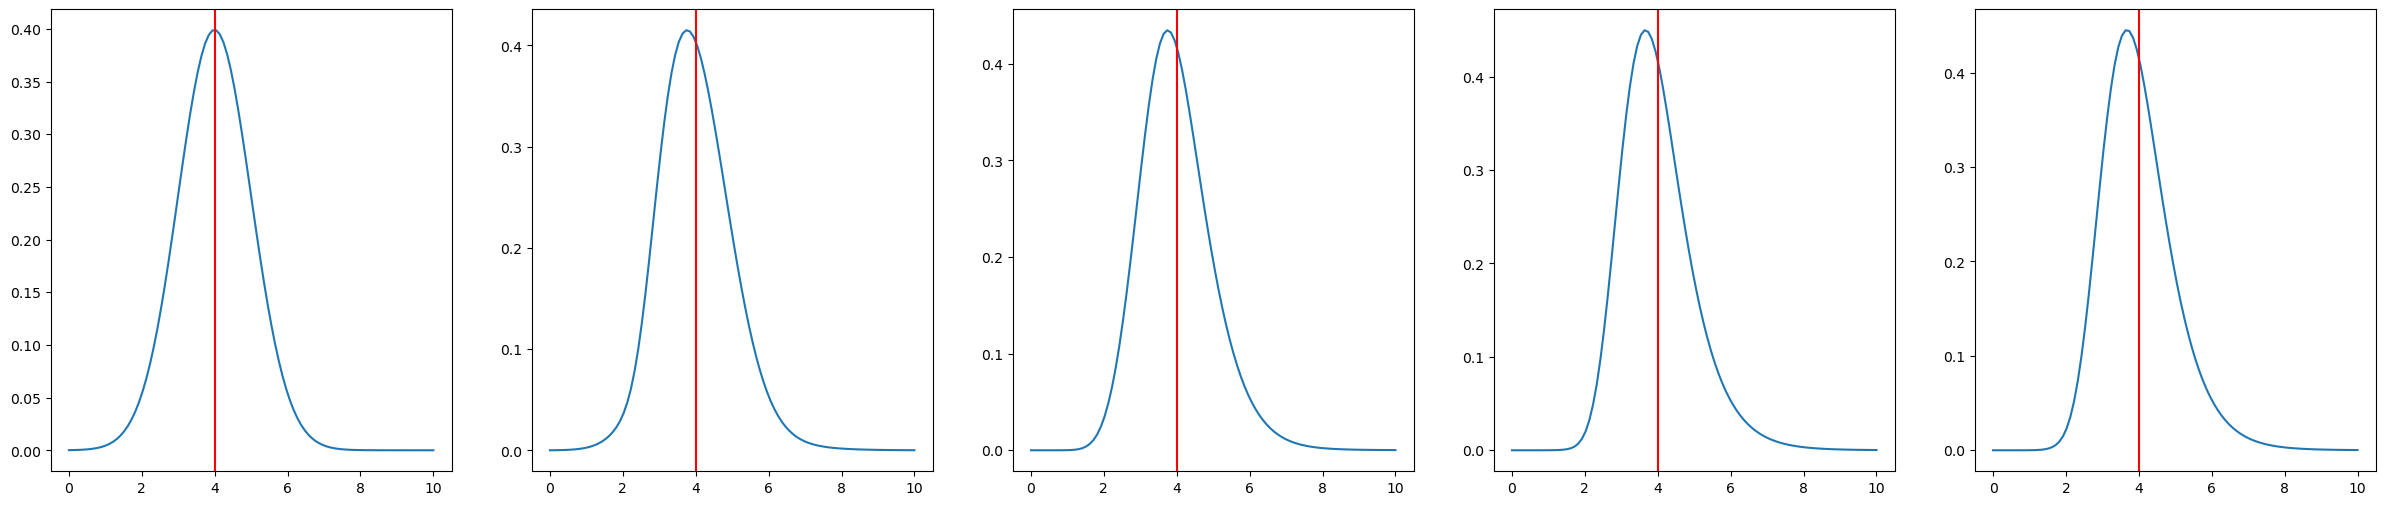

In [ ]:
support = np.linspace(0, 10, 100)

def plot_ensembles(named_weights, mean, variance, support, figsize):
  fig, ax = plt.subplots(1, len(named_weights), figsize=figsize)
  for i in range(len(named_weights)):
    mod = EnsembleDistribution(named_weights[i], mean, variance)
    pdf = mod.pdf(support)
    ax[i].plot(support, pdf)
    ax[i].axvline(mean, color="red")

named_weights = [{"normal": 0.99, "gumbel": 0.01},
                 {"normal": 0.6, "gumbel": 0.4},
                 {"gamma": 0.7, "fisk": 0.3},
                 {"invgamma": 0.3, "lognormal": 0.5, "fisk": 0.2},
                 {"gamma": 0.2, "invgamma": 0.3, "lognormal": 0.3, "fisk": 0.2}]

plot_ensembles(named_weights, MEAN, VARIANCE, support, (30, 6))

# Comparing fitted ensemble distributions to truth

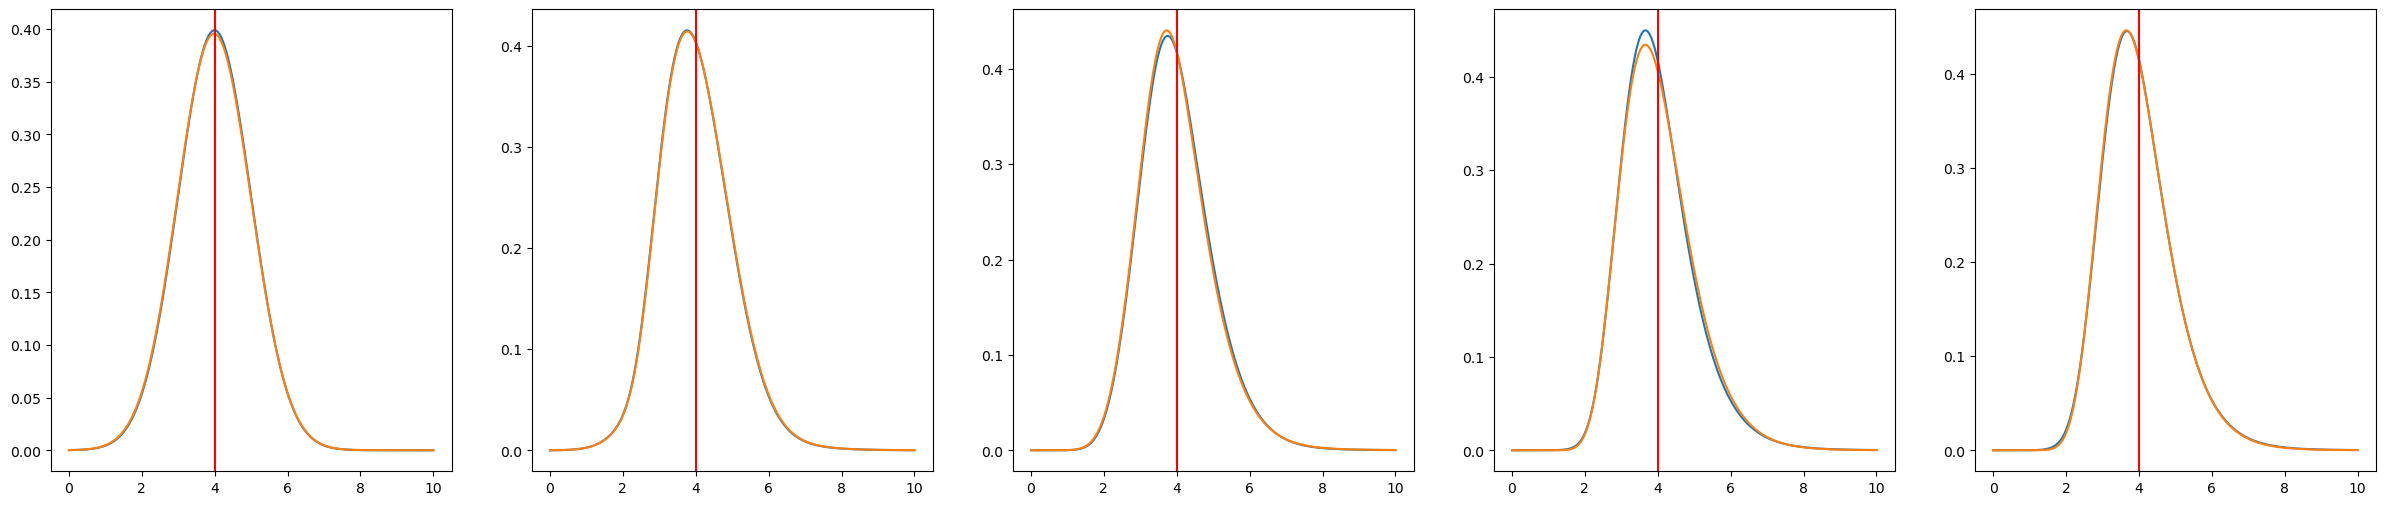

In [ ]:
support = np.linspace(0, 10, 200)

def ensemble_comparison(named_weights, objective, mean, variance, support, figsize):
  fig, ax = plt.subplots(1, len(named_weights), figsize=figsize)
  for i in range(len(named_weights)):
    mod = EnsembleDistribution(named_weights[i], mean, variance)
    mod_draws = mod.rvs(size=10000)
    fit = EnsembleFitter(list(named_weights[i].keys()), objective).fit(mod_draws)
    pdf = mod.pdf(support)
    ax[i].plot(support, pdf)
    ax[i].plot(support, fit.ensemble_distribution.pdf(support))
    ax[i].axvline(mean, color="red")

named_weights = [{"normal": 0.99, "gumbel": 0.01},
                 {"normal": 0.6, "gumbel": 0.4},
                 {"gamma": 0.7, "fisk": 0.3},
                 {"invgamma": 0.3, "lognormal": 0.5, "fisk": 0.2},
                 {"gamma": 0.2, "invgamma": 0.3, "lognormal": 0.3, "fisk": 0.2}]

ensemble_comparison(named_weights, "KS", MEAN, VARIANCE, support, (30, 6))

# Diabetes

current combo: 
 nid            30189
location_id      200
year_id          1.0
sex             Male
age_start3        15
Name: 43747, dtype: object
num. rows: 152
FPG bounds: 3.38888888888889 7.27777777777778
distributions and weights: {'gamma': 3.653057263189397e-12, 'invgamma': 1.6175667552638348e-11, 'lognormal': 6.0711276719388175e-12, 'fisk': 0.9999999999741}


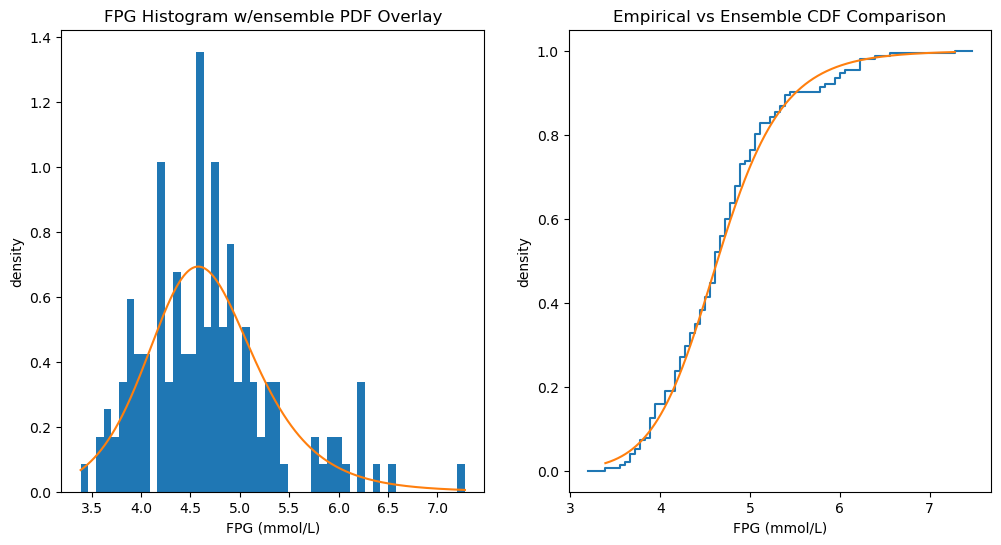

In [ ]:
all_combos = data[['nid', 'location_id', 'year_id', 'sex', 'age_start3']].drop_duplicates()
num_combos = len(all_combos)
rand_idx = random.randint(0, num_combos)
rand_row = all_combos.iloc[rand_idx]
# print row identifiers before crashing
print("current combo: \n", rand_row)

filtered_df = data[(data['nid'] == rand_row["nid"]) &
                 (data['location_id'] == rand_row["location_id"]) &
                 (data['year_id'] == rand_row["year_id"]) &
                 (data['sex'] == rand_row["sex"]) &
                 (data['age_start3'] == rand_row["age_start3"])]

# add small jitter to deal with identical FPG values
fpg = filtered_df["fpg_mmol"].to_numpy()
# fpg = fpg + np.random.normal(loc=0, scale=0.00001, size=len(fpg))
# fit ensemble
distributions = ["gamma", "invgamma", "lognormal", "fisk"]
model = EnsembleFitter(distributions, "KS")
res = model.fit(fpg)
named_weights = {}
for i in range(len(distributions)):
  named_weights[distributions[i]] = res.weights[i]


# prepare matplotlib subplots and support
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
support = np.linspace(np.min(fpg), np.max(fpg), 1000)

# plot histogram vs fitted PDF
ax[0].hist(fpg, density=True, bins=50)
ax[0].plot(support, res.ensemble_distribution.pdf(support))
ax[0].set_xlabel("FPG (mmol/L)")
ax[0].set_ylabel("density")
ax[0].set_title("FPG Histogram w/ensemble PDF Overlay")

# plot eCDF vs fitted CDF
stats.ecdf(fpg).cdf.plot(ax[1])
ax[1].plot(support, res.ensemble_distribution.cdf(support))
# shows individual cdf fits but makes graph too busy
# for i in range(len(distributions)):
#   ax[1].plot(support, res.ensemble_distribution.fitted_distributions[i].cdf(support), color="orange", alpha=0.25)
ax[1].set_xlabel("FPG (mmol/L)")
ax[1].set_ylabel("density")
ax[1].set_title("Empirical vs Ensemble CDF Comparison")

# various diagnostics
num_rows = len(filtered_df)
print("num. rows:", num_rows)
print("FPG bounds:", np.min(fpg), np.max(fpg))
print("distributions and weights:", named_weights)

In [ ]:
temp = EnsembleDistribution(["normal", "gumbel"], [0.7, 0.3], 4, 40)
temp.plot()

TypeError: EnsembleDistribution.__init__() takes 4 positional arguments but 5 were given